In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
import optax
import flax.serialization

In [2]:
# One-hot encoding function
def one_hot_encode(sequence, alphabet="ATGC"):
    mapping = {char: i for i, char in enumerate(alphabet)}
    one_hot = np.zeros((len(sequence), len(alphabet)), dtype=np.float32)
    for i, char in enumerate(sequence):
        if char in mapping:
            one_hot[i, mapping[char]] = 1.0
    return one_hot.flatten()


In [3]:
# Data preprocessing function
def preprocess_data(filepath):
    data = pd.read_csv(filepath)
    sequences = data['Modified_Sequence'].values
    targets = data['new_fold_change'].values
    valid_indices = ~np.isnan(targets)
    sequences = sequences[valid_indices]
    targets = targets[valid_indices]

    # Normalize targets
    targets = (targets - np.min(targets)) / (np.max(targets) - np.min(targets))

    # One-hot encode sequences
    X = np.array([one_hot_encode(seq) for seq in sequences])

    return X, targets


In [4]:
# Define MLP model
class MLP(nn.Module):
    width: int
    depth: int
    
    def setup(self):
        self.layers = [nn.Dense(self.width) for _ in range(self.depth)]
        self.output_layer = nn.Dense(1) 
    
    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
            x = nn.relu(x)
        return self.output_layer(x)

In [5]:
# Training function
def train(model, params, data, epochs=100, lr=1e-3, batch_size=32):
    rng = jax.random.PRNGKey(0)
    X, y = data

    opt = optax.adam(lr)
    opt_state = opt.init(params)

    # Loss function
    def loss_fn(params, X, y):
        preds = model.apply(params, X)
        return jnp.mean((preds.flatten() - y) ** 2)

    loss_and_grads = jax.value_and_grad(loss_fn)

    @jax.jit
    def train_step(params, opt_state, X, y):
        loss, grads = loss_and_grads(params, X, y)
        updates, new_opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, new_opt_state, loss

    for epoch in range(epochs):
        rng, step_rng = jax.random.split(rng)
        indices = jax.random.permutation(step_rng, X.shape[0])
        X, y = jnp.array(X)[indices], jnp.array(y)[indices]

        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            params, opt_state, loss = train_step(params, opt_state, X_batch, y_batch)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    return params

In [6]:
# Save model function
def save_model(params, filepath):
    with open(filepath, 'wb') as f:
        f.write(flax.serialization.to_bytes(params))
    print(f"Model saved: {filepath}")

# Load model function
def load_model(filepath, model, example_input):
    with open(filepath, 'rb') as f:
        params = flax.serialization.from_bytes(model.init(random.PRNGKey(0), example_input), f.read())
    print(f"Model loaded from {filepath}")
    return params

# Filepath 10k sample of U15

file_path = "/Users/zouyuntong/Desktop/Eric's data/U15_sampled_fold_change.csv"

# Preprocess data
X, y = preprocess_data(file_path)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=44)

Epoch 1, Loss: 0.0017
Epoch 11, Loss: 0.0015
Epoch 21, Loss: 0.0013
Epoch 31, Loss: 0.0006
Epoch 41, Loss: 0.0009
Epoch 51, Loss: 0.0037
Epoch 61, Loss: 0.0002
Epoch 71, Loss: 0.0005
Epoch 81, Loss: 0.0005
Epoch 91, Loss: 0.0003
Model saved: /Users/zouyuntong/Desktop/mlp_model_1.pkl
Model loaded from /Users/zouyuntong/Desktop/mlp_model_1.pkl
R^2 Score: 0.6924


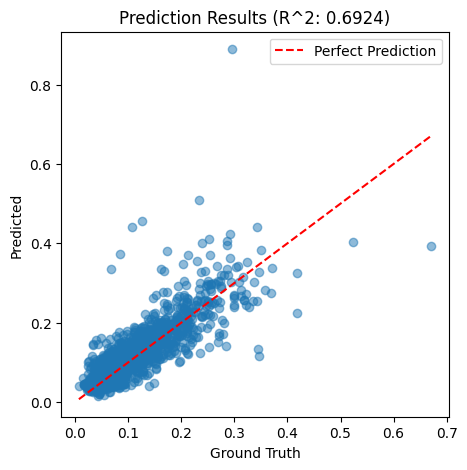

In [10]:

# Initialize model
model = MLP(width=64, depth=3)
example_input = jnp.ones((1, X_train.shape[1]))  # Ensure correct shape
params = model.init(random.PRNGKey(0), example_input)

# Train model
train_data = (jnp.array(X_train), jnp.array(y_train))
params = train(model, params, train_data, epochs=100, lr=1e-3, batch_size=32)

# Save model
save_model(params, "/Users/zouyuntong/Desktop/mlp_model_1.pkl")

# Load model
loaded_params = load_model("/Users/zouyuntong/Desktop/mlp_model_1.pkl", model, example_input)

# Ensure correct shape for apply()
X_test_jax = jnp.array(X_test).reshape(-1, X_train.shape[1])

y_pred = model.apply(loaded_params, X_test_jax).flatten()

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.4f}")

# Plot results
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted")
plt.title(f"Prediction Results (R^2: {r2:.4f})")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Perfect Prediction")
plt.legend()
plt.show()
